# Climate modes and diagnostics

We want to look at climate features during low energy events:
1. Daily events: solar and wind lulls. Pick out most spatially extensive lull-days (separate for each season, e.g. sum lulls over all regions, pick top 10% winter days.
    - daily circulation composites: MSLP, 500gph, 200gph. Do we get H/Ls in similar positions? What is the jet doing? Maybe a plot of wind vectors - nice to see the direction and speed?
2. Anomalous seasons: sum number of events over a season and look at the largest. Sub-question: do we get consecutive seasons with lots of regions experiencing events? This might go better in an earlier notebook.
    - modes of variability: SST, the variable used to calculate SAM. What do ENSO, IOD, SAM look like?
    
And, we want to do this the other way around. Do ENSO, IOD, SAM years lead us to energy lulls?

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '00:30:00'
cores = 8
memory = str(4 * cores) + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

<Client: 'tcp://10.6.73.32:41433' processes=0 threads=0, memory=0 B>

In [5]:
# client.close()
# cluster.close()

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
# %reload_ext autoreload
# %autoreload 2

In [8]:
# import warnings

import xarray as xr
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'

import string
letters = list(string.ascii_lowercase)

In [9]:
import functions as fn

plt_params = fn.get_plot_params()
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [10]:
plt_params

{'lines.linewidth': 1.3,
 'hatch.linewidth': 0.5,
 'font.size': 7,
 'legend.fontsize': 6,
 'legend.columnspacing': 0.7,
 'legend.labelspacing': 0.03,
 'legend.handlelength': 1.0,
 'axes.linewidth': 0.5,
 'axes.titlesize': 8}

In [11]:
years = range(1959, 2022)

data_fp = '/g/data/w42/dr6273/work/data/'

season_dict = fn.get_seasons()

# Load masks

In [12]:
rez_mask = fn.get_rez_mask()

# Load energy source and demand data

Sources: daily wind, daily solar and monthly runoff

In [13]:
rez_100w = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/100w_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['100w']#.compute()

In [14]:
rez_mssrd = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/mssrd_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['mssrd']#.compute()

In [15]:
rez_ro = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/ro_era5_monthly-averaged_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['ro']#.compute()

Annual runoff

In [16]:
rez_ro_ann = rez_ro.resample(time='1YS').sum()

Aus - gridded

In [17]:
aus_100w = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/100w/100w_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_AUS_region.zarr',
    consolidated=True
)['w100']

In [18]:
aus_mssrd = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/msdwswrf/msdwswrf_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_AUS_region.zarr',
    consolidated=True
)['msdwswrf']

Demand: 2m T for GCCSA city regions

In [19]:
gcc_t = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/t2m_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_GCCSA_region_mean.zarr',
    consolidated=True
)['t2m'].compute()

In [20]:
gcc_t = gcc_t - 273.15

Thresholds for event definitions

In [21]:
thresh_100w = rez_100w.chunk({'time': -1}).quantile(0.25, ['time', 'region']) #4 # Close to all region-time 25th percentile of 4.19
thresh_mssrd = rez_mssrd.chunk({'time': -1}).quantile(0.25, ['time', 'region']) #170 # All region-time 25th percentile is 132.7
thresh_ro = rez_ro_ann.chunk({'time': -1}).quantile(0.25, ['time'])
thresh_t_cool = 16
thresh_t_warm = 21

### Events

In [22]:
events_100w = fn.get_events(rez_100w, thresh_100w, tail='lower').compute()

In [23]:
events_mssrd = fn.get_events(rez_mssrd, thresh_mssrd, tail='lower').compute()

In [24]:
events_100w_mssrd = fn.get_compound_events(rez_100w, rez_mssrd, thresh_100w, thresh_mssrd).compute()

### Daily events over all regions

In [25]:
simul_100w = fn.concurrent_lulls(events_100w, [1, 3, 5, 7], rez_mask)
simul_mssrd = fn.concurrent_lulls(events_mssrd, [2, 3, 6, 7], rez_mask)
simul_100w_mssrd = fn.concurrent_lulls(events_100w_mssrd, [3, 7], rez_mask)

### Seasonal events over all regions

In [26]:
season_100w = fn.seasonal_mean(simul_100w)
season_mssrd = fn.seasonal_mean(simul_mssrd)
season_100w_mssrd = fn.seasonal_mean(simul_100w_mssrd)

# Load diagnostics and climate mode indices

### Daily diagnostics

500 hPa geopotential height

In [27]:
daily_z500_anoms = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/z/z_anoms_era5_daily_1400UTC_pl_'+str(years[0])+'-'+str(years[-1])+'_extended_Aus_region.zarr',
    consolidated=True
)['z'].squeeze()

MSLP

In [28]:
daily_mslp = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/mslp/mslp_era5_daily_1400UTC_'+str(years[0])+'-'+str(years[-1])+'_extended_Aus_region.zarr',
    consolidated=True
)['mslp']

In [29]:
daily_mslp_anoms = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/mslp/mslp_anoms_era5_daily_1400UTC_'+str(years[0])+'-'+str(years[-1])+'_extended_Aus_region.zarr',
    consolidated=True
)['mslp']

100u and 100v

In [30]:
daily_u100 = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/100u/100u_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_extended_AUS_region.zarr',
    consolidated=True
)['u100']

In [31]:
daily_v100 = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/100v/100v_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_extended_AUS_region.zarr',
    consolidated=True
)['v100']

Tcc

In [32]:
daily_tcc = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/tcc/tcc_era5_12hr_2000-0800UTC_'+str(years[0])+'-'+str(years[-1])+'_extended_Aus_region.zarr',
    consolidated=True
)['tcc']

In [33]:
daily_tcc_anoms = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/tcc/tcc_anoms_era5_12hr_2000-0800UTC_'+str(years[0])+'-'+str(years[-1])+'_extended_Aus_region.zarr',
    consolidated=True
)['tcc']

In [34]:
# TCC has 0800UTC time. Re-assign to 1400UTC to match other variables
daily_tcc = daily_tcc.assign_coords({'time': daily_u100.time})

In [35]:
daily_tcc_anoms = daily_tcc_anoms.assign_coords({'time': daily_u100.time})

2m T

In [36]:
daily_2t = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/2t/2t_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_extended_AUS_region.zarr',
    consolidated=True
)['t2m']

In [37]:
daily_2t_anoms = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/2t/2t_anoms_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_extended_AUS_region.zarr',
    consolidated=True
)['t2m']

### Monthly diagnostics and seasonal means

HadISST SST anomalies

In [38]:
sst_fp = data_fp + 'hadisst/sst/sst_anom_hadisst_moda_sfc_'+str(years[0])+'-'+str(years[-1])+'.zarr'
sst_anoms = xr.open_zarr(sst_fp, consolidated=True)
sst_anoms = fn.seasonal_mean(sst_anoms)

ERA5 MSLP anomalies

In [39]:
mslp_fp = data_fp + 'era5/mslp/mslp_anom_era5_moda_sfc_'+str(years[0])+'-'+str(years[-1])+'.zarr'
mslp_anoms = xr.open_zarr(mslp_fp, consolidated=True)
mslp_anoms = fn.seasonal_mean(mslp_anoms)

### Climate mode indices

Nino3.4

In [40]:
nino34_fp = data_fp + 'hadisst/climate_modes/hadisst_nino34_'+str(years[0])+'-'+str(years[-1])+'.zarr'
nino34 = xr.open_zarr(nino34_fp, consolidated=True)
nino34 = fn.seasonal_mean(nino34)
nino34 = nino34.compute()

DMI

In [41]:
dmi_fp = data_fp + 'hadisst/climate_modes/hadisst_dmi_'+str(years[0])+'-'+str(years[-1])+'.zarr'
dmi = xr.open_zarr(dmi_fp, consolidated=True)
dmi = fn.seasonal_mean(dmi)
dmi = dmi.compute()

SAM

In [42]:
sam_fp = data_fp + 'era5/climate_modes/era5_sam_'+str(years[0])+'-'+str(years[-1])+'.zarr'
sam = xr.open_zarr(sam_fp, consolidated=True)
sam = fn.seasonal_mean(sam)
sam = sam.compute()

# Daily diagnostics on spatially extensive wind/solar/compound drought days

In [43]:
def get_spatial_events(da, season, q, time_name='time'):
    """
    Subsample the time steps which are spatially compounding,
    defined as when the number of regions experiencing an event
    exceeds a quantile threshold (q). Can be done by season.
    """
    months = fn.get_seasons()[season] # months in this season
    subset_da = fn.month_subset(da, months, time_name) # select data in this season
    thresh = subset_da.quantile(q, time_name) # top q extensive events
    events = subset_da.where(subset_da > thresh)
    n_events = events.count().values # number of events
    years = events.dropna(time_name)[time_name].dt.year.values # Years that events occurred in
    
    return years, events, n_events

In [44]:
def subset_on_events(event_da, diag_da, season, q, time_name='time'):
    """
    Obtain the diagnostic variable array over event years.
    """
    years, events, n_events = get_spatial_events(event_da, season, q, time_name)
    diag = fn.month_subset(diag_da, fn.get_seasons()[season])
    diag = diag.where(events.notnull())
    return years, events, n_events, diag

In [45]:
def composite_data(event_da, diag_da, season, q, time_name='time'):
    """
    Composite (average) the diagnostic array over event years.
    """
    years, events, n_events, diag = subset_on_events(event_da, diag_da, season, q, time_name)
    return years, n_events, diag.mean(time_name)

In [46]:
def get_plot_data(events_dict, diag1, diag2, diag1_name, diag2_name, thresh):
    """
    Compute the data needed for plotting and save to a dictionary.
    We do this so we can tweak the figure without needed to process
    the data each time.
    
    events_dict: dictionary with events for each energy type
    diag1, diag2: dataarrays of diagnostic variables
    diag1_name, diag2_name: str. names of diag vars for dict.
    thresh: threshold used to define 'spatially extensive' events.
    """
    plot_dict = {}
    for season in list(season_dict.keys())[1:]:
        
        plot_dict[season] = {}
        
        for name, var in zip(events_dict.keys(), events_dict.values()):
            plot_dict[season][name] = {}
            
            years, n_events, p_1 = composite_data(
                var,
                diag1,
                season,
                thresh
            )

            _, _, p_2 = composite_data(
                var,
                diag2,
                season,
                thresh
            )
            
            plot_dict[season][name][diag1_name] = p_1.compute()
            plot_dict[season][name][diag2_name] = p_2.compute()
            plot_dict[season][name]['n_events'] = n_events
            
    return plot_dict

In [47]:
def region_data(simul_da, event_da, region_codes, season, thresh):
    """
    Get data of each region's frequency of occurrence
    in spatially extensive event days.
    
    simul_da: simultaneous events i.e. total number of daily events
                across all regions
    event_da: events by region
    region_codes: regions of interest e.g. wind only, wind and solar
    """
    _, events, _ = get_spatial_events(simul_da, season, thresh) # Spatialy extensive events
    # Subset event_da for regions of interest
    event_da = event_da.sel(region=fn.get_regions_from_region_codes(region_codes, rez_mask))
    # Compute average events by region over time
    averages = event_da.where(events.notnull()).mean('time')
    # Sort by frequency
    sort_avg = averages.sortby(averages, ascending=False)
    
    # Colors to plot each region with
    sort_colors = []
    for r in sort_avg.region.values:
        sort_colors.append(region_colors[r[0]])
        
    return {'data': sort_avg, 'colors': sort_colors}

In [48]:
region_colors = {
    'N': plt.cm.tab10(8),
    'O': plt.cm.tab10(0),
    'Q': plt.cm.tab10(9),
    'S': plt.cm.tab10(6),
    'T': plt.cm.tab10(2),
    'V': plt.cm.tab10(1)
}

In [116]:
thresh_spatial = 0.95 # top 5 % spatially extensive days

In [117]:
# Dictionary of daily events by region, with 
#. corresponding region codes
daily_events_dict = {
    'Solar': {
        'data': events_mssrd,
        'codes': [2, 3, 6, 7]
    },
    'Wind': {
        'data': events_100w,
        'codes': [1, 3, 5, 7]
    },
    'Compound': {
        'data': events_100w_mssrd,
        'codes': [3, 7]
    }
}

In [118]:
# Dictionary of droughts across all regions
daily_simul_dict = {
    'Solar': simul_mssrd,
    'Wind': simul_100w,
    'Compound': simul_100w_mssrd
}

In [119]:
# Plotting data - Z500 and MSLP
daily_plot_dict = get_plot_data(
    daily_simul_dict,
    daily_z500_anoms,
    daily_mslp,
    'z',
    'mslp',
    thresh_spatial
)

In [120]:
def get_frequency_text(simul_dict, thresh):
    """
    Get the text for each subplot. Text is the number of event
    days, and percentages of solar/wind events in compound events.
    """
    n_event_text = np.full((4, 3), 'xxx', dtype='object')
    for i, season in enumerate(list(season_dict.keys())[1:]):
        _, solar_events, n_solar = get_spatial_events(simul_dict['Solar'], season, thresh)
        _, wind_events, n_wind = get_spatial_events(simul_dict['Wind'], season, thresh)
        _, compound_events, n_compound = get_spatial_events(simul_dict['Compound'], season, thresh)
        
        solar_in_compound = xr.where(
            (solar_events.notnull()) &
            (compound_events.notnull()),
            1,
            0).sum().values
        wind_in_compound = xr.where(
            (wind_events.notnull()) &
            (compound_events.notnull()),
            1,
            0).sum().values
        
        pc_solar = np.round((solar_in_compound / n_compound) * 100, 1)
        pc_wind = np.round((wind_in_compound / n_compound) * 100, 1)
        
        n_event_text[i, 0] = str(n_solar) + ' (' + str(pc_solar) + '%)'
        n_event_text[i, 1] = str(n_wind) + ' (' + str(pc_wind) + '%)'
        n_event_text[i, 2] = str(n_compound)
        
    return n_event_text

In [147]:
def plot_z_mslp(ax1, ax2, z_da, mslp_da, region_dict, text=None, mslp_anoms=False):
    """
    Plot geopotential height shading and MSLP contours on an axis.
    MSLP can be either full field or anomalies.
    
    Bar plot of regions' tendency to be part of spatially
    extensive days.
    """
    ### =========== Diagnostics subplot
    # print(z_da.min().values, z_da.max().values)
    # print(mslp_da.min().values, mslp_da.max().values)
    # print()
    
    if mslp_anoms:
        m = 1000
        mslp_levels = np.arange(-m, m+1, 100)
        mslp_levels = [i for i in mslp_levels if i != 0]
    else:
        mslp_levels = np.arange(97000, 106000, 500)
    
    # ax1.coastlines(linewidths=0.1)
    ax1.add_feature(
        cartopy.feature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces',
            scale='10m'
        ),
        facecolor='none',
        edgecolor='k',
        lw=.1,
        rasterized=True
    )
    # ax1.set_extent([112, 155, -10, -45])
    
    p = z_da.plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        vmin=-70,
        vmax=70,
        cmap='RdBu_r',
        add_colorbar=False,
        rasterized=True
    )
    mslp_da.plot.contour(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        levels=mslp_levels,
        colors='k',
        linewidths=0.4
    )
    
    ax1.set_title('', fontsize=plt_params['font.size'] / 1.7, pad=0)
    
    if isinstance(text, str):
        ax1.text(0.055, 0.94, text, ha='left', va='top',
                 bbox=dict(facecolor='white', alpha=1, lw=0.5),
                 transform=ax1.transAxes)
    
    # ============ Region frequency barplot
    x = region_dict['data'].values
    y = region_dict['data'].region.values
    ax2.barh(y, x, color=region_dict['colors'], height=.8)
    
    ax2.set_xlim(0, 1)
    ax2.set_xticks([0,1.])
    ax2.set_xticklabels('')
    
    ax2.set_ylim(-0.5, len(y))
    ax2.set_yticks([])
    
    for pos in ['top', 'right']:
        ax2.spines[pos].set_visible(False)
    
    return p

In [175]:
def plot_synoptics(plot_dict, cbar_label, cbar_ticks, cbar_extend, uv_plot_dict=None, anoms=False, save_fig=False):
    """
    Plot synoptic maps with side bar plots showing which regions feature
    in spatially extensive composites.
    
    plot_dict: dictionary containing data for plotting on map
    uv_plot_dict: disctionary containing u and v data for quiver plot
    cbar_label: colorbar label for da1
    cbar_ticks: ticks for colorbar
    cbar_extend: extend mode for colorbar
    anoms: Bool. Whether second variable is anomalies or not.
    """
    with plt.rc_context(plt_params):
        fig = plt.figure(figsize=(6.9, 5.1)) 

        n_event_text = get_frequency_text(daily_simul_dict, thresh_spatial)
        
        da1_name = list(plot_dict['Winter']['Solar'].keys())[0]
        da2_name = list(plot_dict['Winter']['Solar'].keys())[1]

        axes = []

        count = 0
        for i, season in enumerate(list(season_dict.keys())[1:]):
            for j, (name, var) in enumerate(zip(daily_simul_dict.keys(), daily_simul_dict.values())):
                # Get map data
                p1 = plot_dict[season][name][da1_name]
                p2 = plot_dict[season][name][da2_name]
                
                # Get region data for bar plot
                p_region = region_data(
                    daily_simul_dict[name],
                    daily_events_dict[name]['data'],
                    daily_events_dict[name]['codes'],
                    season,
                    thresh_spatial
                )
                
                # Dynamically program axes positions
                bottom1 = 0.75 - 0.25 * i
                top1 = 1 - 0.25 * i

                bottom2 = 0.76 - 0.25 * i
                top2 = 0.99 - 0.25 * i

                left1 = 0 + 0.33 * j
                right1 = 0.2 + 0.33 * j

                left2 = 0.21 + 0.33 * j
                right2 = 0.3 + 0.33 * j

                # Set up axes
                gs1 = fig.add_gridspec(nrows=1, ncols=1, left=left1, right=right1, bottom=bottom1, top=top1)
                gs2 = fig.add_gridspec(nrows=1, ncols=1, left=left2, right=right2, bottom=bottom2, top=top2)

                ax1 = plt.subplot(gs1[0], projection=ccrs.PlateCarree())
                ax2 = plt.subplot(gs2[0])
                axes.append([ax1, ax2])

                # Plot
                if uv_plot_dict is None:
                    p = plot_z_mslp(ax1, ax2, p1, p2, p_region,
                                    text=letters[count] + ') ' + n_event_text[i, j], mslp_anoms=anoms)
                else:
                    u = uv_plot_dict[season][name]['u']
                    v = uv_plot_dict[season][name]['v']
                    p, p_w = plot_wind_tcc_t(ax1, ax2, p1, u, v, p2, p_region,
                                             text=letters[count] + ') ' + n_event_text[i, j], tcc_anoms=anoms)
                    
                count += 1

        plt.subplots_adjust(hspace=0., wspace=0.0)

        # Labels and titles
        axes[0][0].text(0.5, 1.05, 'Solar', ha='center', transform=axes[0][0].transAxes)
        axes[1][0].text(0.5, 1.05, 'Wind', ha='center', transform=axes[1][0].transAxes)
        axes[2][0].text(0.5, 1.05, 'Compound', ha='center', transform=axes[2][0].transAxes)

        axes[0][0].text(-0.1, 0.5, 'Winter', rotation=90, va='center', transform=axes[0][0].transAxes)
        axes[3][0].text(-0.1, 0.5, 'Spring', rotation=90, va='center', transform=axes[3][0].transAxes)
        axes[6][0].text(-0.1, 0.5, 'Summer', rotation=90, va='center', transform=axes[6][0].transAxes)
        axes[9][0].text(-0.1, 0.5, 'Autumn', rotation=90, va='center', transform=axes[9][0].transAxes)

        # Colorbar
        cb_ax1 = fig.add_axes([0.1, -0.1, 0.36, 0.02])
        cb1 = fig.colorbar(p, cax=cb_ax1, orientation='horizontal', ticks=cbar_ticks, extend=cbar_extend)
        cb1.ax.set_xlabel(cbar_label)

        # Barplot legend
        labels = ['NSW', 'Offshore', 'QLD', 'SA', 'TAS', 'VIC']
        handles = [plt.Rectangle((0,0),1,1, color=i) for i in region_colors.values()]
        axes[-1][1].legend(handles, labels, ncols=6, loc=(-4, -.5), frameon=False)

        # Barplot xticks and labels
        for i in [-3, -2, -1]:
            axes[i][1].set_xticklabels([0, 1])
            axes[i][1].set_xlabel('Relative freq. [-]')
            
        # Quiver legend
        if uv_plot_dict is None:
            pass
        else:
            qk = axes[9][0].quiverkey(p_w, -3.1, -0.4, 10, label=r'10 ms$^{-1}$', labelpos='N', labelcolor='k')
            
        if save_fig:
            plt.savefig('./figures/Fig2_synoptics.pdf', format='pdf', dpi=400, bbox_inches='tight')

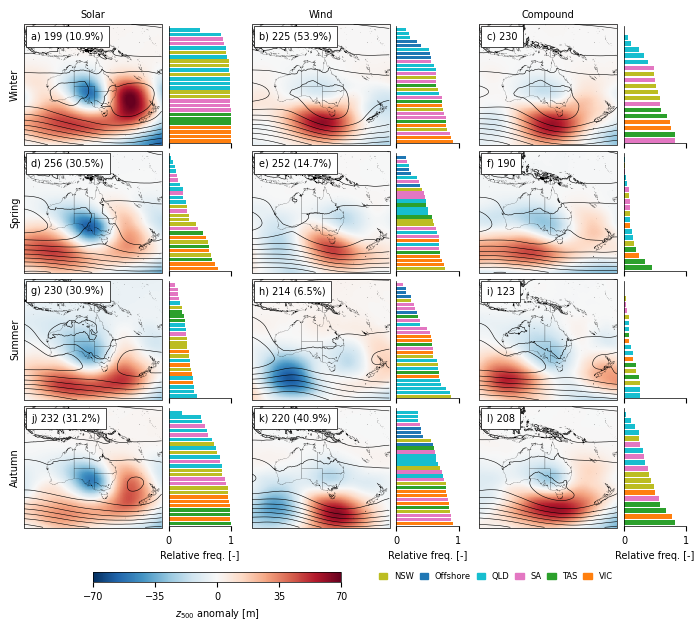

In [135]:
plot_synoptics(
    daily_plot_dict,
    r'$z_{500}$ anomaly [m]',
    np.arange(-70, 71, 35),
    'neither'
)

In [137]:
# Plotting data - Wind speed/direction (u and v)
daily_plot_u_v = get_plot_data(
    daily_simul_dict,
    daily_u100,
    daily_v100,
    'u',
    'v',
    thresh_spatial
)

In [138]:
# Plotting data - tcc anoms and T anoms
daily_plot_tcc_t2m_anoms = get_plot_data(
    daily_simul_dict,
    daily_tcc_anoms,
    daily_2t_anoms,
    'tcc_anoms',
    '2t_anoms',
    thresh_spatial
)

In [264]:
def plot_wind_tcc_t(ax1, ax2, tcc_da, u_da, v_da, t_da, region_dict, text=None, tcc_anoms=False):
    """
    Plot total cloud cover shading, wind direction/speed arrows and
    temperature anomalies as contours on an axis.
    TCC can be either full field or anomalies.
    
    Bar plot of regions' tendency to be part of spatially
    extensive days.
    """
    ### =========== Diagnostics subplot     
    if tcc_anoms:
        # m = 1
        # tcc_levels = np.arange(-m, m+1, 0.1)
        # tcc_levels = [i for i in mslp_levels if i != 0]
        tcc_vmin = -0.3
        tcc_vmax = 0.3
    else:
        # mslp_levels = np.arange(0, 1, 0.1)
        tcc_vmin = 0
        tcc_vmax = 1
    
    ax1.add_feature(
        cartopy.feature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces',
            scale='10m'
        ),
        facecolor='none',
        edgecolor='k',
        lw=.1,
        rasterized=True
    )
    ax1.coastlines(lw=.3, rasterized=True)
    ax1.set_extent([105, 170, 0, -50], crs=ccrs.PlateCarree())
    
    # ===== TCC shading
    p = tcc_da.plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        vmin=tcc_vmin,
        vmax=tcc_vmax,
        cmap='PuOr',
        add_colorbar=False,
        rasterized=True
    )
    
    # ====== Wind Quiver plot
    step = 20
    p_w = ax1.quiver(
        u_da.lon.values[::step],
        u_da.lat.values[::step],
        u_da.values[::step,::step],
        v_da.values[::step,::step],
        angles='xy',
        scale=2,
        scale_units='xy',
        width=0.005,
        # headwidth=8,
        transform=ccrs.PlateCarree(),
        # rasterized=True
    )
    
    # ====== Temperature anomaly contours
    m = 20
    levels = np.arange(-m, m+1, 1)
    levels = [i for i in levels if i != 0]
    p_t = t_da.plot.contour(
        ax=ax1,
        levels=levels,
        colors=colors[3],
        transform=ccrs.PlateCarree(),
        linewidths=.5
    )
    try:
        ax1.clabel(p_t, np.array([-1, 1]), fmt='%d', color=colors[3])
    except:
        pass
    
    ax1.set_title('', fontsize=plt_params['font.size'] / 1.7, pad=0)
    
    if isinstance(text, str):
        ax1.text(0.055, 0.94, text, ha='left', va='top',
                 bbox=dict(facecolor='white', alpha=1, lw=0.5),
                 transform=ax1.transAxes)
    
    # ============ Region frequency barplot
    x = region_dict['data'].values
    y = region_dict['data'].region.values
    ax2.barh(y, x, color=region_dict['colors'], height=.5)
    
    ax2.set_xlim(0, 1)
    ax2.set_xticks([0,1.])
    ax2.set_xticklabels('')
    
    ax2.set_ylim(-0.5, len(y))
    ax2.set_yticks([])
    
    for pos in ['top', 'right']:
        ax2.spines[pos].set_visible(False)
    
    return p, p_w

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: No contour levels were found within the data range.
  result = super().contour(*args, **kwargs)
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: No contour levels were found within the data range.
  result = super().contour(*args, **kwargs)


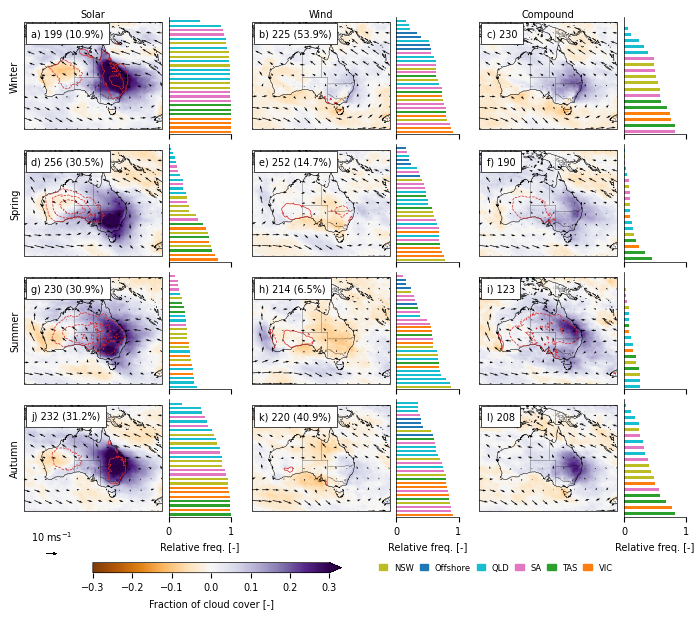

In [265]:
plot_synoptics(
    daily_plot_tcc_t2m_anoms,
    'Fraction of cloud cover [-]',
    np.arange(-0.3, 0.31, 0.1),
    'max',
    daily_plot_u_v,
    anoms=True,
    save_fig=True
)

In [280]:
# plot_synoptics(
#     daily_plot_tcc_tcc_anoms,
#     'Fraction of cloud cover [-]',
#     np.arange(0, 1.01, 0.1),
#     daily_plot_u_v
# )

### PDFs of city temperatures during normal versus drought days

In [281]:
def hist_t_plot(ax, season, city):
    """
    Plot histograms of temperature for a season,
    and on solar, wind or compound days (also in that season).
    """
    if season == 'Winter':
        tmin = -5
        tmax = 25
    elif (season == 'Spring') | (season == 'Autumn'):
        tmin = 0
        tmax = 30
    else:
        tmin = 5
        tmax = 35
    
    fill_alpha = 0.3

    months = season_dict[season]
    b = np.linspace(tmin, tmax, len(range(tmin, tmax)) + 1)
    bins, hist = fn.hist_data(fn.month_subset(gcc_t.sel(region=city), months), b)
    p_clim = ax.plot(bins, hist, color='k', lw=0.8, alpha=0.8, zorder=0, label='All')
    # ax.fill_between(bins, 0, hist, color='k', alpha=fill_alpha - 0.1)

    for var_name, var, color in zip(
        ['Solar', 'Wind', 'Both'],
        [simul_mssrd, simul_100w, simul_100w_mssrd],
        [colors[1], colors[0], colors[4]]
        # [simul_100w_mssrd],
        # [colors[4]]
    ):
        _, _, _, d = subset_on_events(var, gcc_t.sel(region=city), season, thresh_spatial)

        bins, hist = fn.hist_data(d, b)
        # ax.plot(bins, hist, color=color, lw=0.8, alpha=1)
        ax.fill_between(bins, 0, hist, color=color, alpha=fill_alpha, zorder=1, label=var_name)
        
        ax.axvline(16, ls='--', lw=0.5, color=colors[0])
        ax.axvline(21, ls='--', lw=0.5, color=colors[3])
        
        ax.set_ylim(-0.015, 0.3)
        ax.set_yticks([0, 0.15, 0.3])
        
        ax.set_xticks(np.arange(tmin, tmax+1, 10))
        
        ax.legend()

In [282]:
city_names = {
    'SYD': 'Sydney',
    'MLB': 'Melbourne',
    'BNE': 'Brisbane',
    'ADL': 'Adelaide',
    'HBA': 'Hobart',
    'ACT': 'Canberra'
}

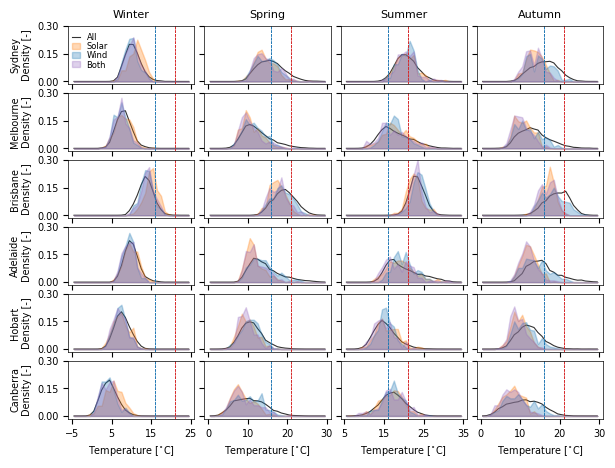

In [283]:
with plt.rc_context(plt_params):
    
    fig, axes = plt.subplots(6, 4, figsize=(6.9, 5.1))
    
    for j, season in enumerate(list(season_dict.keys())[1:]):
        for i, city in enumerate(gcc_t['region'].values):
        
            hist_t_plot(axes[i,j], season, city)
            
            if i == 0:
                axes[i,j].set_title(season)
                
            if i < 5:
                axes[i,j].set_xticklabels('')
            else:
                axes[i,j].set_xlabel(r'Temperature [$^{\circ}$C]')
            if j > 0:
                axes[i,j].set_yticklabels('')
            else:
                axes[i,j].set_ylabel(city_names[city] + '\nDensity [-]')
                
            if (i == 0) & (j == 0):
                axes[i,j].legend(loc=(0., 0.2), frameon=False)
            else:
                axes[i,j].legend().set_visible(False)
                
    plt.subplots_adjust(hspace=0.15, wspace=0.08)
    
    plt.savefig('./figures/Fig3_temperature_pdfs.pdf', format='pdf', dpi=400, bbox_inches='tight')

# Monthly diagnostics on spatially extensive wind/solar/compound drought years

Figure ideas:
1. PDFs of climate mode indices, with spatially compounding months/seasons marked (crosses, lines) or the composite mean marked.
2. Composite maps of SST and MSLP (plus some other variables eventually?) over spatially compounding months/seasons. Could also show which regions have events here - maybe counts/percentage of times each region is counted.
3. Correlation between each climate mode and wind, solar

Should be done separately for each season.

### Correlation

Get seasonal mean of gridded solar and wind to align with format of mode indices

In [51]:
aus_100w_seasonal = fn.seasonal_mean(aus_100w)
aus_mssrd_seasonal = fn.seasonal_mean(aus_mssrd)

Also do this for number of compound droughts

In [52]:
aus_events_100w_mssrd = fn.get_compound_events(aus_100w, aus_mssrd, thresh_100w, thresh_mssrd)
aus_CE_seasonal = fn.seasonal_mean(aus_events_100w_mssrd)

In [44]:
cor_dict = {}
for season, months in zip(season_dict.keys(), season_dict.values()):
    cor_dict[season] = {}
    
    if season == 'Annual': # Mean over all seasons in each year
        a = aus_100w_seasonal.resample(time='1YS').mean()
        b = aus_mssrd_seasonal.resample(time='1YS').mean()
        c = aus_CE_seasonal.resample(time='1YS').mean()
    else: # otherwise select month corresponding to season
        a = aus_100w_seasonal.isel(time=aus_100w_seasonal.time.dt.month == months[1])
        b = aus_mssrd_seasonal.isel(time=aus_mssrd_seasonal.time.dt.month == months[1])
        c = aus_CE_seasonal.isel(time=aus_CE_seasonal.time.dt.month == months[1])
    
    for mode, mode_da in zip(
        ['ENSO', 'IOD', 'SAM'],
        [nino34['nino34'], dmi['dmi'], sam['sam']]
    ):
        cor_dict[season][mode] = {}
        
        if season == 'Annual':
            m = mode_da.resample(time='1YS').mean()
        else:
            m = mode_da.isel(time=mode_da.time.dt.month == months[1])
        
        cor_a = xr.corr(a, m, dim='time').compute()
        cor_b = xr.corr(b, m, dim='time').compute()
        cor_c = xr.corr(c, m, dim='time').compute()
        
        cor_dict[season][mode]['100w'] = cor_a
        cor_dict[season][mode]['mssrd'] = cor_b
        cor_dict[season][mode]['compound'] = cor_c

In [55]:
def plot_cor(season):
    with plt.rc_context(plt_params):
        
        fig, ax = plt.subplots(3, 3, dpi=120, subplot_kw={'projection': ccrs.PlateCarree()})

        for i, mode in enumerate(['ENSO', 'IOD', 'SAM']):
                ax[i, 0].coastlines(rasterized=True)
                ax[i, 1].coastlines(rasterized=True)
                ax[i, 2].coastlines(rasterized=True)

                cor_dict[season][mode]['mssrd'].plot(ax=ax[i, 0], cmap='PiYG', vmin=-0.5, vmax=0.5)
                cor_dict[season][mode]['100w'].plot(ax=ax[i, 1], cmap='PiYG', vmin=-0.5, vmax=0.5)
                cor_dict[season][mode]['compound'].plot(ax=ax[i, 2], cmap='PiYG_r', vmin=-0.5, vmax=0.5)

                if i == 0:
                    ax[i, 0].set_title('Solar')
                    ax[i, 1].set_title(season + '\nWind')
                    ax[i, 2].set_title('Both (droughts)')
                else:
                    ax[i, 0].set_title('')
                    ax[i, 1].set_title('')
                    ax[i, 2].set_title('')

                ax[i,0].text(-0.05, 0.5, mode, rotation=90, ha='center', va='center', transform=ax[i, 0].transAxes)
                # ax[i, 0].text(0.05, 0.9, ', '.join([mode, season]), transform=ax[i, 0].transAxes)
                # ax[i, 1].text(0.05, 0.9, ', '.join([mode, season]), transform=ax[i, 1].transAxes)

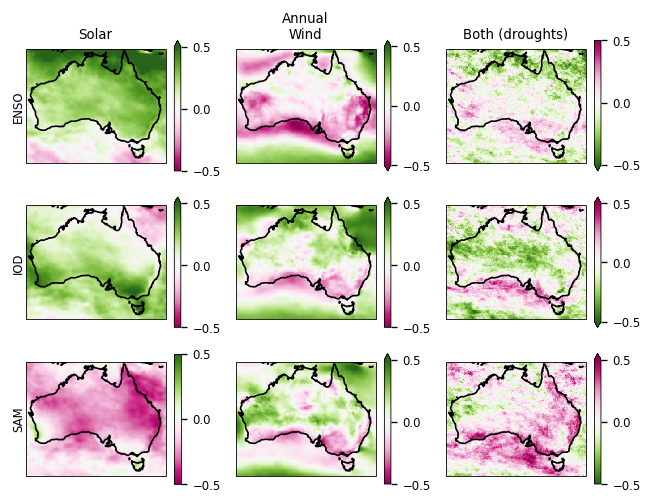

In [60]:
plot_cor('Annual')

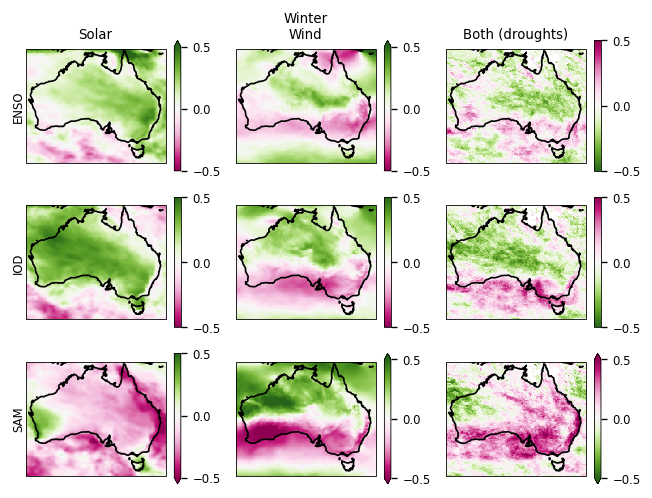

In [56]:
plot_cor('Winter')

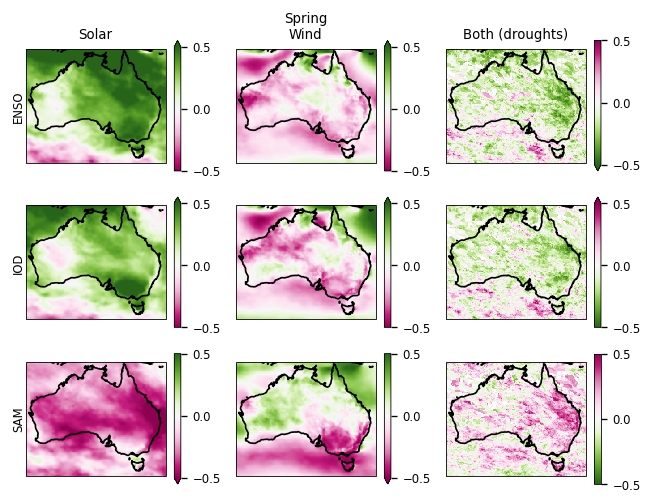

In [57]:
plot_cor('Spring')

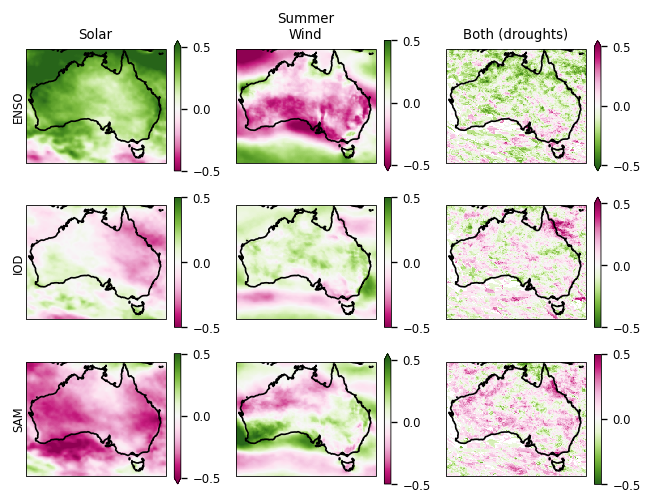

In [58]:
plot_cor('Summer')

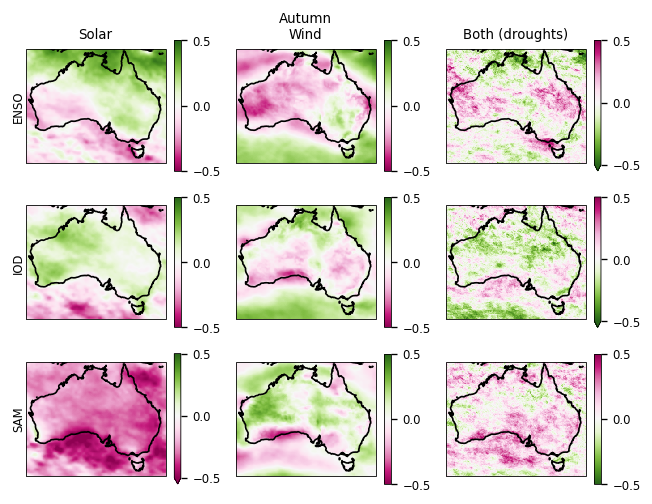

In [59]:
plot_cor('Autumn')

### Set variables

In [49]:
thresh_spatial = 0.9

### Composite maps

In [50]:
def plot_sst_mslp(ax, sst_da, mslp_da, years, text=None):
    """
    Plot SST shading and MSLP contours on an axis.
    """
    m = 5000
    mslp_levels = np.arange(-m, m+1, 100)
    mslp_levels = [i for i in mslp_levels if i != 0]
    
    ax.set_extent([0, 359.99, 20, -90])
    ax.coastlines(linewidths=0.3, rasterized=True)
    
    p = p_sst.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        vmin=-1.8,
        vmax=1.8,
        cmap='RdBu_r',
        add_colorbar=False,
        rasterized=True
    )
    p_mslp.plot.contour(
        ax=ax,
        transform=ccrs.PlateCarree(),
        levels=mslp_levels,
        colors='k',
        linewidths=0.3
    )
    
    if isinstance(text, str):
        ax.text(0.93, 0.93, text, ha='right', va='top',
                bbox=dict(facecolor='white', alpha=1, lw=0.5),
                transform=ax.transAxes)
    
    format_years = [str(i) for i in years]
    title = ', '.join(format_years)
    ax.set_title(title, fontsize=plt_params['font.size'] / 1.7, pad=0)
    
    return p

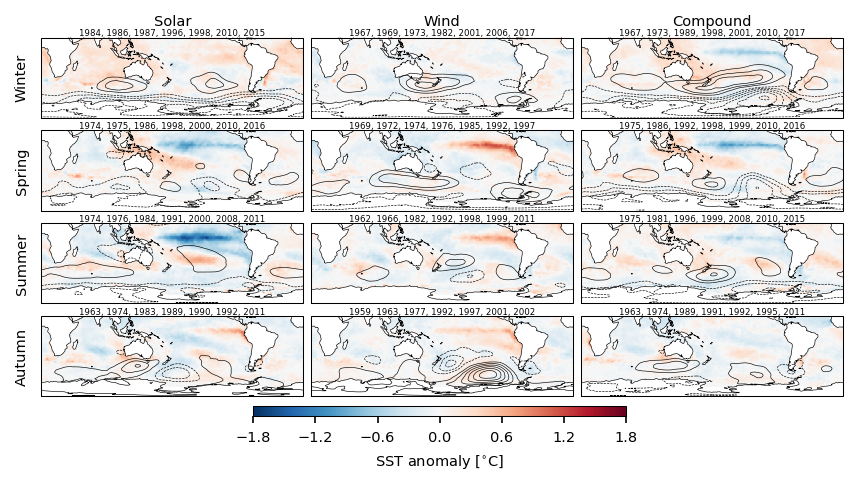

In [293]:
with plt.rc_context(plt_params):
    fig = plt.figure(figsize=(6.9, 3.2), dpi=150)
    
    axes = []
    for i in range(12):
        axes.append(fig.add_subplot(4, 3, i+1, projection=ccrs.PlateCarree(central_longitude=180)))
    
    i = 0
    for season in list(season_dict.keys())[1:]:
        for var in [season_mssrd, season_100w, season_100w_mssrd]:
            years, n_events, p_sst = composite_data(
                var,
                sst_anoms['sst_anom'],
                season,
                thresh_spatial
            )

            _, _, p_mslp = composite_data(
                var,
                mslp_anoms['mslp_anom'],
                season,
                thresh_spatial
            )

            ax = axes[i]
            p = plot_sst_mslp(ax, p_sst, p_mslp, years)
            
            i += 1
                        
    plt.subplots_adjust(hspace=0.02, wspace=0.03)
    
    axes[0].text(0.5, 1.15, 'Solar', ha='center', transform=axes[0].transAxes)
    axes[1].text(0.5, 1.15, 'Wind', ha='center', transform=axes[1].transAxes)
    axes[2].text(0.5, 1.15, 'Compound', ha='center', transform=axes[2].transAxes)
    
    axes[0].text(-0.1, 0.5, 'Winter', rotation=90, va='center', transform=axes[0].transAxes)
    axes[3].text(-0.1, 0.5, 'Spring', rotation=90, va='center', transform=axes[3].transAxes)
    axes[6].text(-0.1, 0.5, 'Summer', rotation=90, va='center', transform=axes[6].transAxes)
    axes[9].text(-0.1, 0.5, 'Autumn', rotation=90, va='center', transform=axes[9].transAxes)
    
    cb_ax1 = fig.add_axes([0.33, 0.08, 0.36, 0.02])
    cb1 = fig.colorbar(p, cax=cb_ax1, orientation='horizontal', ticks=np.arange(-1.8, 1.9, 0.6))
    cb1.ax.set_xlabel(r'SST anomaly [$^{\circ}$C]')
    
    plt.savefig('./figures/Fig4_composites.pdf', format='pdf', dpi=400, bbox_inches='tight')

### Climate modes PDFS

In [295]:
def mode_hist(ax, event_da_list, diag_da, season, q, xmin=-2.5, xmax=2.5, time_name='time'):
    """
    Get the histogram of diag_da for the season, and the individual
    points for values of diag_da on event years for each event in
    event_da_list.
    """
    event_values = []
    # Loop through event_da_list (usually wind, solar and compound) to get mode index
    #  values on events.
    for i, event_da in enumerate(event_da_list):
        years, events, _, diag_events = subset_on_events(event_da, diag_da, season, q, time_name)
        event_values.append(diag_events.where(events.notnull()).dropna(time_name).values)
    diag_season = fn.month_subset(diag_da, fn.get_seasons()[season])

    # Histogram
    b = np.linspace(xmin, xmax, 20)
    bins, hist = fn.hist_data(diag_season, b)
    
    ax.plot(bins, hist, color='k', lw=0.5)
    ax.fill_between(bins, 0, hist, color='k', alpha=0.15)
    
    # +- x * standard deviations
    std = diag_season.std(time_name).values
    ax.axvline(std * 1, ls='--', lw=0.5, color='k')
    ax.axvline(std * -1, ls='--', lw=0.5, color='k')
    
    # Get ymax rounded up
    ymax = fn.round_decimals_up(np.max(hist), 1)
    # Use this to set y location of markers
    central_y = ymax / 9
    lower_y = central_y / 2.3
    upper_y = central_y * 1.8
    
    for values, y, marker, color, label in zip(
        event_values,
        [lower_y, central_y, upper_y],
        ['*', 'x', '.'],
        [colors[1], colors[0], colors[4]],
        ['Solar', 'Wind', 'Compound']
    ):
        s = ax.scatter(values, np.repeat(y, len(values)), color=color, marker=marker, s=10, lw=0.5, label=label)
        
    ax.set_xlim(xmin, xmax)
    
    # yticks (surely a better way exists...)
    if ymax > 1:
        ax.set_yticks(np.arange(0, 1.9, 0.6))
    elif (ymax <= 1) & (ymax > 0.8):
        ax.set_yticks(np.arange(0, 1.1, 0.5))
    elif (ymax <= 0.8) & (ymax > 0.5):
        ax.set_yticks(np.arange(0, 0.81, 0.4))
    else:
        ax.set_yticks(np.arange(0, 0.5, 0.2))
        
    return s

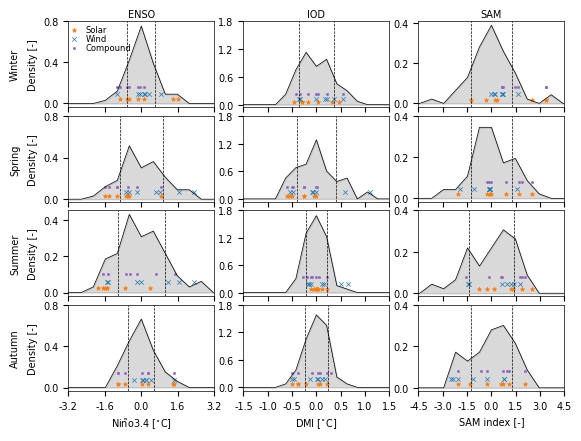

In [296]:
with plt.rc_context(plt_params):
    fig = plt.figure()
    
    axes = []
    for i in range(12):
        axes.append(fig.add_subplot(4, 3, i+1))
    
    i = 0
    for season in list(season_dict.keys())[1:]:
        for mode, xmin, xmax in zip(
            [nino34['nino34'], dmi['dmi'], sam['sam']],
            [-5, -2, -7],
            [5, 2, 7]
        ):
            
            ax = axes[i]
            s = mode_hist(
                ax,
                [season_mssrd, season_100w, season_100w_mssrd],
                mode,
                season,
                thresh_spatial,
                xmin,
                xmax
            )
            
            i += 1
            
    plt.subplots_adjust(hspace=0.1, wspace=0.2)
    
    axes[0].text(0.5, 1.05, 'ENSO', ha='center', transform=axes[0].transAxes)
    axes[1].text(0.5, 1.05, 'IOD', ha='center', transform=axes[1].transAxes)
    axes[2].text(0.5, 1.05, 'SAM', ha='center', transform=axes[2].transAxes)
    
    axes[0].text(-0.4, 0.5, 'Winter', rotation=90, va='center', transform=axes[0].transAxes)
    axes[3].text(-0.4, 0.5, 'Spring', rotation=90, va='center', transform=axes[3].transAxes)
    axes[6].text(-0.4, 0.5, 'Summer', rotation=90, va='center', transform=axes[6].transAxes)
    axes[9].text(-0.4, 0.5, 'Autumn', rotation=90, va='center', transform=axes[9].transAxes)
    
    # ENSO xticks (and y labels)
    for i in [0, 3, 6, 9]:
        axes[i].set_xlim(-3.2, 3.2)
        axes[i].set_xticks(np.arange(-3.2, 3.21, 1.6))
        axes[i].set_xticklabels('')
        axes[i].set_ylabel('Density [-]')
    axes[9].set_xticklabels([np.round(x, 1) for x in np.arange(-3.2, 3.21, 1.6)])
    
    # IOD xticks
    for i in [1, 4, 7, 10]:
        axes[i].set_xlim(-1.5, 1.5)
        axes[i].set_xticks(np.arange(-1.5, 1.51, 0.5))
        axes[i].set_xticklabels('')
    axes[10].set_xticklabels(np.arange(-1.5, 1.51, 0.5))
    
    # SAM xticks
    for i in [2, 5, 8, 11]:
        axes[i].set_xlim(-4.5, 4.5)
        axes[i].set_xticks(np.arange(-4.5, 4.6, 1.5))
        axes[i].set_xticklabels('')
    axes[11].set_xticklabels(np.arange(-4.5, 4.6, 1.5))
    
    # xlabels
    axes[9].set_xlabel(r'Ni$\mathrm{\tilde{n}}$o3.4 [$^{\circ}$C]')
    axes[10].set_xlabel(r'DMI [$^{\circ}$C]')
    axes[11].set_xlabel('SAM index [-]')
    
    # legend
    l = axes[0].legend(frameon=False, loc=(-0.01, 0.6), framealpha=1)
    # l.get_frame().set_alpha(1)
    
    plt.savefig('./figures/Fig5_mode_pdfs.pdf', format='pdf', dpi=400, bbox_inches='tight')

# Difference in drought prob between +ve and -ve phase of modes

Compute lull frequency during +ve phase years, subtract lull frequency during -ve phase years, plot map.

In [51]:
def seasonal_sum(da, time_name='time'):
    """
    Calculate seasonal sums. Currently assumes da starts in January.
    First aggregates to monthly, then shifts everything forwards
    one month, then aggregates over 3 months.
    """
    first_month = da[time_name].dt.month.values[0]
    if first_month != 1:
        raise ValueError("First month should be January. Adjust da or function.")
        
    # First aggregate to monthly as we want to shift a month ahead
    m_da = da.resample({time_name: '1MS'}).sum()
    # Now shift a month ahead and calculate 3-monthly means
    return m_da.shift({time_name: 1}).resample({time_name: '3MS'}).sum(skipna=False)

In [52]:
def subset_by_phase(event_da, diag_da, season, time_name='time'):
    """
    Subset an events dataArray by positive and negative phases of climate modes.
    
    event_da: DataArray of daily events
    diag_da: mode DataArray
    season: season of interest
    """
    # diag_da subset by season
    diag_season = fn.month_subset(diag_da, fn.get_seasons()[season])
    # +- x standard deviation thresholds
    std = diag_season.std(time_name).values
    low_thresh = std * -1
    high_thresh = std * 1
    
    # Events subset by diag_season
    low_events = event_da.where(diag_season < low_thresh)
    high_events = event_da.where(diag_season > high_thresh)
    
    return low_events, high_events

In [53]:
def event_diff(event_da, diag_da, season, scale=None, time_name='time'):
    """
    Difference in number of events, computed as event frequency during
    positive mode phases minus event frequency during negative mode phases.
    
    Can be scaled by the standard deviation to say e.g. wind droughts during
    positive ENSO are more frequent on average that during negative ENSO by
    2 standard deviations.
    """
    # Subset events by negative and positive phases of mode
    neg, pos = subset_by_phase(event_da, diag_da, season, time_name)
    
    neg_m = neg.mean(time_name)
    pos_m = pos.mean(time_name)
    diff = (pos_m - neg_m)
    
    if scale == 'std':
        return  diff / event_da.std(time_name)
    else:
        return diff

First get gridded events

In [54]:
aus_events_mssrd = fn.get_events(aus_mssrd, thresh_mssrd, tail='lower')
aus_events_100w = fn.get_events(aus_100w, thresh_100w, tail='lower')
aus_events_100w_mssrd = fn.get_compound_events(aus_100w, aus_mssrd, thresh_100w, thresh_mssrd)

Now get the seasonal totals

In [55]:
aus_events_mssrd_seasonal = fn.seasonal_mean(aus_events_mssrd).compute()
aus_events_100w_seasonal = fn.seasonal_mean(aus_events_100w).compute()
aus_events_both_seasonal = fn.seasonal_mean(aus_events_100w_mssrd).compute()

In [56]:
aus_events_mssrd_seasonal_total = seasonal_sum(aus_events_mssrd).compute()
aus_events_100w_seasonal_total = seasonal_sum(aus_events_100w).compute()
aus_events_both_seasonal_total = seasonal_sum(aus_events_100w_mssrd).compute()

In [57]:
def plot_mode_diff(ax, event_da, mode_da, season, scale, label):
    """
    Plot difference in mean event frequency between positive
    and negative phases of a climate mode.
    """
    ax.set_extent([112, 155, -10, -44])
    ax.add_feature(
        cartopy.feature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces',
            scale='10m'
        ),
        facecolor='none',
        edgecolor='k',
        lw=.1,
        rasterized=True
    )
    ax.add_feature(
        cartopy.feature.OCEAN, facecolor='white', zorder=1, rasterized=True
    )
    ax.coastlines(lw=.3, rasterized=True, zorder=2)
    
    diff = event_diff(event_da, mode_da, season, scale)
    
    if scale == 'std':
        vmin = -2
        vmax = 2
    else:
        vmin = -10
        vmax = 10
        
    # Set cmap limits and ensure cbar extends correctly
    p_min = diff.min().values
    p_max = diff.max().values
    
    if (p_min < vmin) & (p_max <= vmax):
        cbar_extend = 'min'
    elif (p_min < vmin) & (p_max > vmax):
        cbar_extend = 'both'
    elif (p_min >= vmin) & (p_max <= vmax):
        cbar_extend = 'neither'
    elif (p_min >= vmin) * (p_max > vmax):
        cbar_extend = 'max'
    else:
        raise ValueError('Something weird happening with vmin/vmax')
        
    cbar_kwargs = {'extend': cbar_extend, 'label': label}
    
    diff.plot(cmap='RdBu_r', vmin=vmin, vmax=vmax, cbar_kwargs=cbar_kwargs, rasterized=True, zorder=0)
    ax.set_title('')

In [58]:
def fig_mode_diff(events_list, season, scale, cbar_label='Number of\nevents [days]', save_fig=False):
    """
    Plot diff maps for this season.
    """
    with plt.rc_context(plt_params):
        fig = plt.figure(figsize=(6., 4), dpi=120)
        axes = []

        i = 0
        for mode_da in [nino34['nino34'], dmi['dmi'], sam['sam']]:
            for event_da in events_list:
                if i in [2, 5, 8]:
                    label = cbar_label
                else:
                    label = ''

                ax = fig.add_subplot(3, 3, i+1, projection=ccrs.PlateCarree())
                ax.text(0.03, 0.9, letters[i] + ')', transform=ax.transAxes)
                axes.append(ax)

                plot_mode_diff(ax, event_da, mode_da, season, scale, label)

                i += 1
                
        axes[0].set_title('Solar')
        axes[1].set_title('Wind')
        axes[2].set_title('Both')
        
        axes[0].text(-0.15, 0.5, r'ENSO$^{+} - $ENSO$^{-}$', rotation=90, va='center', transform=axes[0].transAxes)
        axes[3].text(-0.15, 0.5, r'IOD$^{+} - $IOD$^{-}$', rotation=90, va='center', transform=axes[3].transAxes)
        axes[6].text(-0.15, 0.5, r'SAM$^{+} - $SAM$^{-}$', rotation=90, va='center', transform=axes[6].transAxes)
        
        plt.subplots_adjust(hspace=0.15, wspace=0.0)
        
        if save_fig:
            plt.savefig('./figures/Fig6_phase_diff_'+season+'.pdf', format='pdf', dpi=400, bbox_inches='tight')

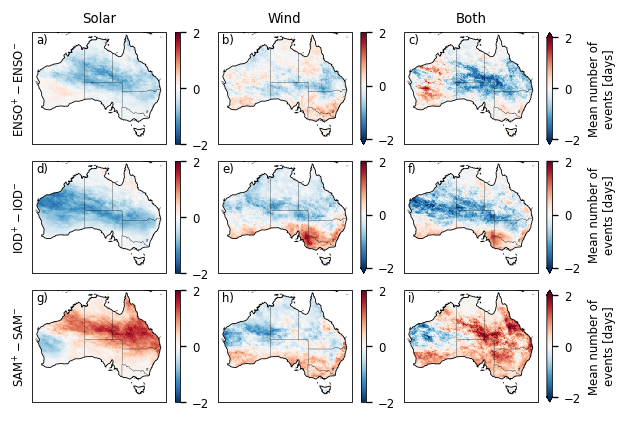

In [108]:
fig_mode_diff([
    aus_events_mssrd_seasonal,
    aus_events_100w_seasonal,
    aus_events_both_seasonal
], 'Winter', scale='std', cbar_label='Mean number of\nevents [days]')

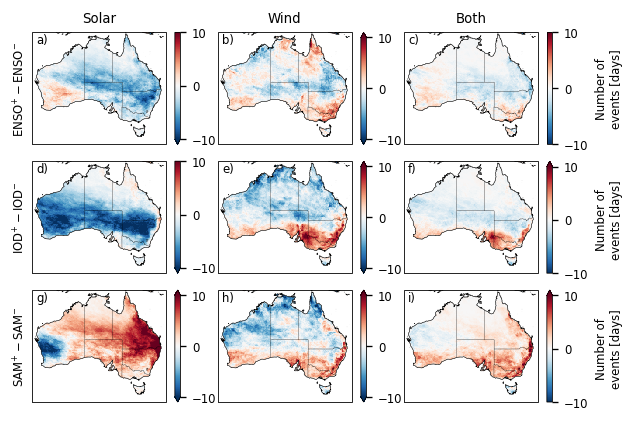

In [59]:
fig_mode_diff([
    aus_events_mssrd_seasonal_total,
    aus_events_100w_seasonal_total,
    aus_events_both_seasonal_total
], 'Winter', scale=None, save_fig=True)

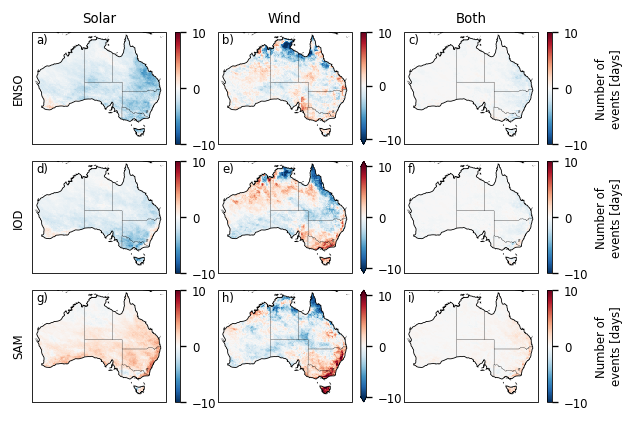

In [91]:
fig_mode_diff([
    aus_events_mssrd_seasonal_total,
    aus_events_100w_seasonal_total,
    aus_events_both_seasonal_total
], 'Spring', scale=None)

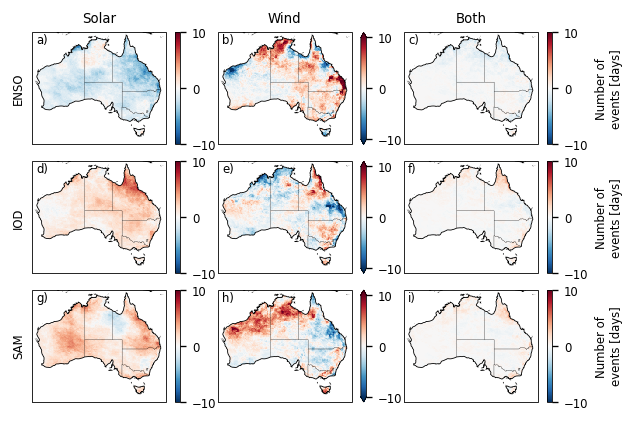

In [92]:
fig_mode_diff([
    aus_events_mssrd_seasonal_total,
    aus_events_100w_seasonal_total,
    aus_events_both_seasonal_total
], 'Summer', scale=None)

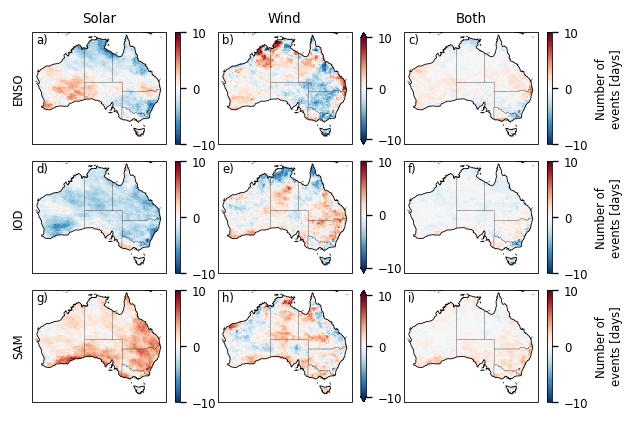

In [93]:
fig_mode_diff([
    aus_events_mssrd_seasonal_total,
    aus_events_100w_seasonal_total,
    aus_events_both_seasonal_total
], 'Autumn', scale=None)

# Close cluster

In [62]:
client.close()
cluster.close()